# PROYECTO FINAL DE MODELOS COMPUTACIONALES II CON PYTHON
## Por: Oswaldo Natanael Rojano Castro

### El objetivo del proyecto en general es aplicar nuestros conocimientos adquiridos a lo largo de todo el semestre en base al análisis y procesamiento de diferentes tipos de datos, principalmente para probemas de clasificación llamese supervisada o no supervisada. Dicho lo anterior, en base al dataset que usted (profe Fer, especifico porque no sé si Oswaldo también lo vaya a revisar xd) nos proporcionó realicé lo que considero un buen análisis de dichos datos, primero empecé por un análisis exploratorio y pues lo más destacable es que son imágenes de 4 diferentes tipos de clases y son poco más de 7k, desde ese momento pensé, por mi bien mental y el de mi computadora no usaré CNN dado la enorme demanda que significa para mi pobre equipo de cómputo, entonces ¿qué decidí hacer?, pues bueno, como anteriormente haíamos usado PCA para analisar otro tipo de imágenes con el profe Oswaldo, creí pertinente extraer 11 característcas de las imágenes y hacerles PCA para poder crear un CSV con dichos PC más representativos de cada imagen y usar modelos de clasificación supervisada que me permitieran obtener la mayor Precisión psobile. Dado este preámbulo procederé a demostrar qué hice para lograrlo.

In [9]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from skimage import img_as_ubyte
from scipy.stats import entropy, skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC

import xgboost as xgb

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


### Hacer los CSV de los PCA para usarlos en mis modelos

In [ ]:

base_path = r'C:\Users\oswal\OneDrive\Documentos\GitHub\Neurociencias-2025-2\S06_proyecto\dataset'

data = []

# Iterar sobre cada conjunto (Training y Testing)
for set_name in ['Training', 'Testing']:
    set_path = os.path.join(base_path, set_name)
    
    for class_name in ['glioma', 'meningioma', 'notumor', 'pituitary']:
        class_path = os.path.join(set_path, class_name)
        
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is None:
                continue

            # Calcular estadísticas básicas
            mean_val = np.mean(img)
            std_val = np.std(img)
            entropy_val = entropy(img.ravel())
            skewness_val = skew(img.ravel())
            kurtosis_val = kurtosis(img.ravel())
            contrast_val = np.max(img) - np.min(img)
            
        
            glcm = graycomatrix(img_as_ubyte(img), distances=[1], angles=[0], symmetric=True, normed=True)
            energy_val = graycoprops(glcm, 'energy')[0, 0]
            asm_val = energy_val ** 2
            homogeneity_val = graycoprops(glcm, 'homogeneity')[0, 0]
            correlation_val = graycoprops(glcm, 'correlation')[0, 0]
            dissimilarity_val = np.mean(np.abs(img - np.mean(img)))

          
            data.append([filename, set_name, class_name, mean_val, std_val, entropy_val, skewness_val, kurtosis_val,
                         contrast_val, energy_val, asm_val, homogeneity_val, dissimilarity_val, correlation_val])

# Crear un DataFrame con los resultados
df = pd.DataFrame(data, columns=['NombreImagen', 'Set', 'Clase', 'Mean', 'SD', 'Entropia', 'Skewness', 'Kurtosis',
                                 'Contrast', 'Energy', 'ASM', 'Homogeneidad', 'Dissimilitud', 'Correlacion'])

# Separar características y etiquetas
X = df.iloc[:, 3:]  # Todas las columnas excepto NombreImagen, Set y Clase
y = df['Clase']      # Etiquetas de clasificación

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Aplicar PCA para reducir la dimensionalidad
pca = PCA(n_components=5)  # Número de componentes principales
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Crear DataFrames con los datos transformados
df_train_pca = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(5)])
df_test_pca = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(5)])

# Agregar las etiquetas al dataset transformado
df_train_pca['Clase'] = y_train.values
df_test_pca['Clase'] = y_test.values

# Guardar los nuevos datasets en CSV
df_train_pca.to_csv('dataset_train_pca.csv', index=False)
df_test_pca.to_csv('dataset_test_pca.csv', index=False)

print("Dataset de entrenamiento y prueba con PCA guardados exitosamente.")


### Una vez teniendo mis CSV lo que hice fue usar una RNA de dos capas (una con 64 y otra de 32) ya que pensé por la expeeriencia que había tenido con este modelo que sería la mejor opción teniendo ya variables categóricas de mis datos, la sorpresa fue que nel, realmente la precisión que me daba era bastante baja unu.

In [5]:

# 🔹 Cargar los datasets
df_train = pd.read_csv('dataset_train_pca.csv')
df_test = pd.read_csv('dataset_test_pca.csv')

# 🔹 Separar características (X) y etiquetas (y)
X_train = df_train.iloc[:, :-1]  # Todas las columnas excepto la última (Clase)
y_train = df_train.iloc[:, -1]   # Última columna (Clase)

X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

# 🔹 Convertir etiquetas a valores numéricos
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

# 🔹 Definir la Red Neuronal
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Capa oculta 1
    keras.layers.Dense(32, activation='relu'),  # Capa oculta 2
    keras.layers.Dense(len(np.unique(y_train)), activation='softmax')  # Capa de salida (Clasificación)
])

# 🔹 Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 🔹 Entrenar el modelo
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# 🔹 Evaluar rendimiento
y_pred = np.argmax(model.predict(X_test), axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión en test: {accuracy:.2f}')


Epoch 1/50
352/352 [==============================] - 2s 4ms/step - loss: 0.8696 - accuracy: 0.6502 - val_loss: 0.7926 - val_accuracy: 0.6747
Epoch 2/50
352/352 [==============================] - 1s 4ms/step - loss: 0.7500 - accuracy: 0.6995 - val_loss: 0.7117 - val_accuracy: 0.7196
Epoch 3/50
352/352 [==============================] - 2s 5ms/step - loss: 0.7101 - accuracy: 0.7193 - val_loss: 0.6916 - val_accuracy: 0.7203
Epoch 4/50
352/352 [==============================] - 1s 4ms/step - loss: 0.6912 - accuracy: 0.7321 - val_loss: 0.6830 - val_accuracy: 0.7224
Epoch 5/50
352/352 [==============================] - 1s 4ms/step - loss: 0.6788 - accuracy: 0.7332 - val_loss: 0.6630 - val_accuracy: 0.7395
Epoch 6/50
352/352 [==============================] - 2s 4ms/step - loss: 0.6616 - accuracy: 0.7423 - val_loss: 0.6496 - val_accuracy: 0.7345
Epoch 7/50
352/352 [==============================] - 1s 3ms/step - loss: 0.6461 - accuracy: 0.7399 - val_loss: 0.6576 - val_accuracy: 0.7473
Epoch 

### Como salió muy baja la precisión, opté por cambiar algunos parámetros para ver si podría mejorar mi modelo, principalmente aumenté el número de épocas 

In [ ]:

# 🔹 Cargar los datasets
df_train = pd.read_csv('dataset_train_pca.csv')
df_test = pd.read_csv('dataset_test_pca.csv')

# 🔹 Separar características (X) y etiquetas (y)
X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1]

X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

# 🔹 Convertir etiquetas a valores numéricos
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

# 🔹 Definir la Red Neuronal mejorada con más ajustes
model = keras.Sequential([
    keras.layers.Dense(128),
    keras.layers.LeakyReLU(alpha=0.01),  # Usé Leaky ReLU en vez de ReLU
    keras.layers.BatchNormalization(),  # Batch Normalization para estabilizar el aprendizaje
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(64),
    keras.layers.LeakyReLU(alpha=0.01),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(32),
    keras.layers.LeakyReLU(alpha=0.01),
    
    keras.layers.Dense(len(np.unique(y_train)), activation='softmax')  # Capa de salida
])

# 🔹 Ajustar el optimizador con una tasa de aprendizaje baja
optimizer = keras.optimizers.Adam(learning_rate=0.0003)  
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 🔹 Entrenar con más épocas y un batch size más grande
model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test))

# 🔹 Evaluar rendimiento
y_pred = np.argmax(model.predict(X_test), axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión mejorada en test: {accuracy:.2f}')


### Al ver que nomás no mejoraba la cosa, decidí mejor cambiar de modelo por SVM ya que como los datos ya han sido reducidos con PCA, SVM podría encontrar fronteras óptimas entre clases, enos dependiente de hiperparámetros, y a diferencia de RNA, donde hay que afinar neuronas y capas, SVM optimiza automáticamente el margen entre clases.

In [6]:

# 🔹 Cargar los datasets PCA
df_train = pd.read_csv('dataset_train_pca.csv')
df_test = pd.read_csv('dataset_test_pca.csv')

# 🔹 Separar características (X) y etiquetas (y)
X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1]

X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

# 🔹 Convertir etiquetas a valores numéricos
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

# 🔹 Definir y entrenar el modelo SVM
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')  # Kernel RBF para mejor separación de clases
svm_model.fit(X_train, y_train)

# 🔹 Hacer predicciones
y_pred = svm_model.predict(X_test)

# 🔹 Evaluar rendimiento
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo SVM en test: {accuracy:.2f}')


Precisión del modelo SVM en test: 0.72


### La cosa no está funcionando bien, así que obté por cambiar una vez más mi modelo a uno que me llamó la atención y que no había visto antes, el XGBoost, ya que maneja bien datasets grandes y medianos (como este xd), optimiza cada árbol con boosting y corrige errores de modelos anteriores. Incluso puede tener un mejor manejo de outliers y ruido en los datos uwu.

In [7]:

# 🔹 Cargar los datasets PCA
df_train = pd.read_csv('dataset_train_pca.csv')
df_test = pd.read_csv('dataset_test_pca.csv')

# 🔹 Separar características (X) y etiquetas (y)
X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1]

X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

# 🔹 Convertir etiquetas a valores numéricos
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

# 🔹 Definir y entrenar el modelo XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

# 🔹 Hacer predicciones
y_pred = xgb_model.predict(X_test)

# 🔹 Evaluar rendimiento
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo XGBoost en test: {accuracy:.2f}')


Precisión del modelo XGBoost en test: 0.80


### Misma situación mejorar parámtetros para ver si podemos mejorar el modelo unu.

In [8]:

# 🔹 Cargar los datasets PCA
df_train = pd.read_csv('dataset_train_pca.csv')
df_test = pd.read_csv('dataset_test_pca.csv')

# 🔹 Separar características (X) y etiquetas (y)
X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1]

X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

# 🔹 Convertir etiquetas a valores numéricos
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

# 🔹 Definir y entrenar el modelo XGBoost optimizado
xgb_model = xgb.XGBClassifier(
    n_estimators=200,        # Más árboles
    learning_rate=0.05,      # Tasa de aprendizaje más baja
    max_depth=8,             # Mayor profundidad
    subsample=0.8,           # Usa solo 80% de los datos en cada árbol
    colsample_bytree=0.8,    # Usa 80% de las características en cada árbol
    random_state=42
)

xgb_model.fit(X_train, y_train)

# 🔹 Hacer predicciones
y_pred = xgb_model.predict(X_test)

# 🔹 Evaluar rendimiento
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión optimizada del modelo XGBoost en test: {accuracy:.2f}')


Precisión optimizada del modelo XGBoost en test: 0.83


### En efecto, sí mejoró, y no considero que un 0.83 de precisión sea mala considerando que quizás el PCA pudiera no haber sido la mejor manera de empezar mi análisis de los datos, pero en vista de las limitaciones técnicas para realizar una CNN me doy por bien servido con este modelo de clasificación.

44/44 [==============================] - 0s 3ms/step

Métricas de RNA (150 épocas):
Accuracy: 0.76
F1-score: 0.75
Recall: 0.76
Precisión: 0.75

Métricas de SVM:
Accuracy: 0.72
F1-score: 0.72
Recall: 0.72
Precisión: 0.73

Métricas de XGBoost mejorado:
Accuracy: 0.83
F1-score: 0.83
Recall: 0.83
Precisión: 0.83


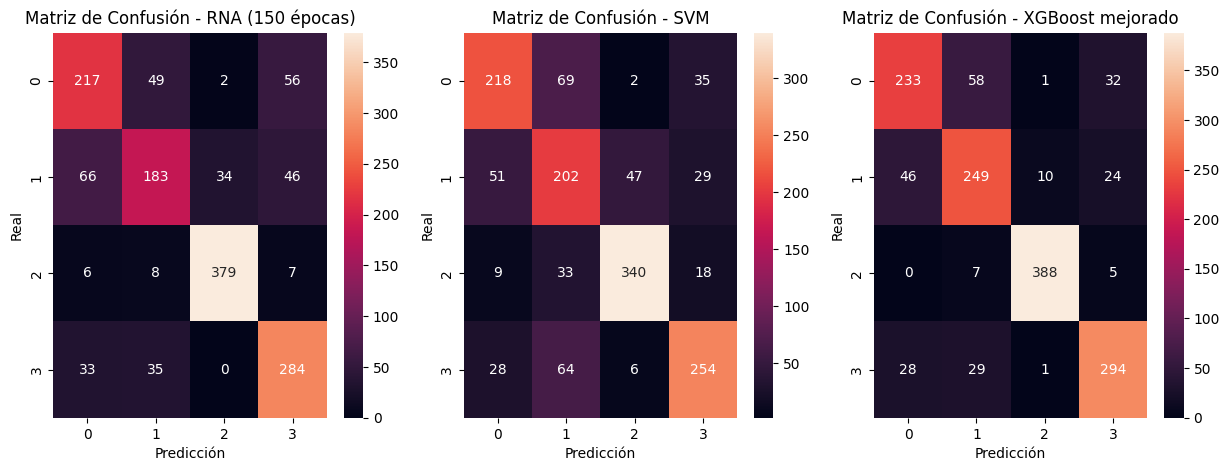

In [16]:

# 🔹 Predicciones RNA
y_pred_rna = model.predict(X_test)
y_pred_rna = np.argmax(y_pred_rna, axis=1)  # Convertimos predicciones en clases

# 🔹 Predicciones SVM
y_pred_svm = svm_model.predict(X_test)

# 🔹 Predicciones XGBoost
y_pred_xgb = xgb_model.predict(X_test)

# 🔹 Cálculo de métricas
models = {
    "RNA (150 épocas)": y_pred_rna,
    "SVM": y_pred_svm,
    "XGBoost mejorado": y_pred_xgb
}

metrics = {}

for model_name, y_pred in models.items():
    metrics[model_name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred, average="weighted"),
        "Recall": recall_score(y_test, y_pred, average="weighted"),
        "Precisión": precision_score(y_test, y_pred, average="weighted")
    }

# 🔹 Mostrar métricas
for model_name, values in metrics.items():
    print(f"\nMétricas de {model_name}:")
    for metric, value in values.items():
        print(f"{metric}: {value:.2f}")

# 🔹 Matrices de confusión
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (model_name, y_pred) in enumerate(models.items()):
    conf_matrix = confusion_matrix(y_test, y_pred)
    ax = axes[i]
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='rocket', ax=ax)
    ax.set_title(f'Matriz de Confusión - {model_name}')
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Real')

plt.show()


In [13]:
print(encoder.classes_)  # Estoe es el orden de las clases en la matriz de confusión. XD

['glioma' 'meningioma' 'notumor' 'pituitary']


# CONCLUSIÓN

### Con todo esto, lo que puedo concluir de mi análisis es que, al menos para este dataset en particular el partir de PCA (con las métricas que saqué) puede no ser lo mejor y meter quizás uan CNN pudiera mejorar muchísimo la clasificación, esto mismo por la naturaleza de los datos (pues son imágenes), pero a pesar de haber manejado poca o mucha información que me pudieran dar los PC considero que me fue bastante bien para no haber usado la totalidad de la información de cada imagen.